# Detect disruptions in plasma current plot

In [11]:
import numpy as np
import matplotlib.pyplot as plt

import s3fs
import xarray as xr
import dask
import zarr


In [12]:
# Function to detect change points using a basic moving average method
def detect_change_points(time, intensity, window_size=50, threshold=2.0):
    """
    Detects change points based on the difference in moving average intensity.

    Args:
    - time (np.array): Time array.
    - intensity (np.array): Intensity array.
    - window_size (int): Size of the window for calculating moving average.
    - threshold (float): Threshold for detecting significant changes.

    Returns:
    - change_points (list): List of times when significant changes are detected.
    """
    moving_avg = np.convolve(intensity, np.ones(window_size) / window_size, mode='valid')
    diff = np.abs(np.diff(moving_avg))

    change_indices = np.where(diff > threshold)[0] + window_size  # Adjust index for valid region
    change_points = time[change_indices]

    return change_points

In [13]:
endpoint = "https://s3.echo.stfc.ac.uk"
fs = s3fs.S3FileSystem(endpoint_url=endpoint, anon=True)

In [14]:
amc = xr.open_zarr(fs.get_mapper("s3://mast/level1/shots/26000.zarr" + '/amc'))
plasma_current = amc['plasma_current']
plasma_current = plasma_current.sel(time=plasma_current.time > 0)
plasma_current = plasma_current.sel(time=plasma_current.time < .4)


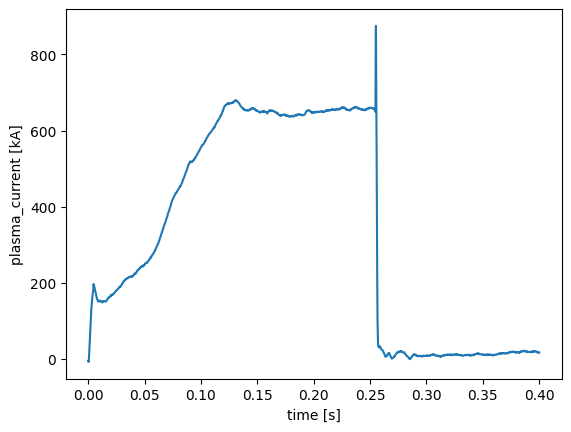

In [19]:
plot1 = plasma_current.plot()

In [16]:
cp = detect_change_points(plasma_current.time, plasma_current, window_size=3, threshold=20)
cp


<xarray.DataArray 'time' (time: 12)> Size: 48B
array([0.255 , 0.2552, 0.2554, 0.2556, 0.2558, 0.256 , 0.2562, 0.2564, 0.2566,
       0.2568, 0.257 , 0.2572], dtype=float32)
Coordinates:
  * time     (time) float32 48B 0.255 0.2552 0.2554 ... 0.2568 0.257 0.2572
Attributes:
    units:    s

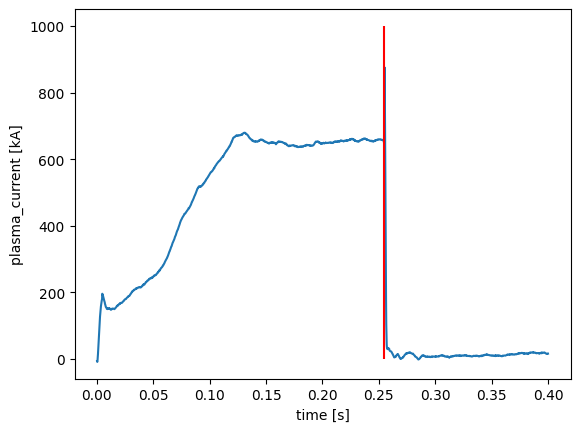

In [22]:
plasma_current.plot()
plt.vlines(cp[0], 0, 1000, color='r')

In [18]:
list(amc.coords.values())[0]

<xarray.DataArray 'time' (time: 30000)> Size: 120kB
array([-2.    , -1.9998, -1.9996, ...,  3.9994,  3.9996,  3.9998],
      dtype=float32)
Coordinates:
  * time     (time) float32 120kB -2.0 -2.0 -2.0 -1.999 ... 3.999 3.999 4.0 4.0
Attributes:
    units:    s